# Product Defects Detection with YOLO

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
#!unzip /content/data.zip

In [5]:
#!pip freeze > requirements.txt


In [6]:
#!type requirements.txt

In [7]:
!pip install numpy
!pip install pandas
import numpy as np # linear algebra
import pandas as pd

# 1. Import Libraries and Packages

In [8]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
!pip install imagesize
!pip install ptitprince
!pip install onnx2pytorch


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 9.0 MB/s eta 0:00:00
  Created wheel for ptitprince: filename=ptitprince-0.2.7-py3-none-any.whl size=10655 sha256=e54d063481c822b59b099f05b72ee14fda4c0918fa968d8b1dee4602811c76db
  Stored in directory: /root/.cache/pip/wheels/0e/43/31/e76a3bf61865543f076a9d9eb027a740caefb379424ecba4e8
Successfully built ptitprince
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 96.9 MB/s eta 0:00:00


In [10]:
# !git clone https://github.com/WongKinYiu/yolov7
# !cd yolov7 && wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

In [11]:
!pip install opencv-python

In [12]:
!pip install matplotlib

!pip install seaborn
!pip install matplotlib


In [13]:
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import seaborn as sns
import re

In [14]:
#pip uninstall numpy

In [15]:
#!pip install pillow


In [19]:
!pip install ptitprince
!pip install colorama
from colorama import Fore, Back, Style



Packages used:

In [20]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import json
import sys
import os
import shutil
from distutils.dir_util import copy_tree
import imagesize
import ptitprince as pt
from shutil import copyfile


pd.set_option('display.max_columns', None)

# Visualization and Colorama (for colored console output)
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

Yolov7 is setting the seed automatically at 0 for random.seed, np.random.seed and init_torch_seeds in the function init_seeds that can be found in yolov7/utils/general.py. Note however that complete reproducibility across algorithm releases and CPU/GPU is not garanteed.

In [ ]:
# conda install numpy


In [21]:
# !grep -w init_seeds 'yolov7/utils/general.py' -A 4 #for linux
!findstr /c:"init_seeds" yolov7\utils\general.py


/bin/bash: line 1: findstr: command not found


Photos were taken using a Panasonic camera (DMC-TZ7). All images were width 640 by height 480 pixels. Photos contained multiple glass jars with jar lids that were intact or damaged. Damage could be subtle or severe, and categories were holes, deformations or scratches. Since there was a lack of training data, these categories were merged to a single category. There are a variety of confounding factors that make it difficult for machine vision to detect defects, such as luminance variation, light reflection and color. Jars were photographed in different positions and were rotated randomly. Training data consisted of 124 images and validation of 39 images. 5 unseen test images were added as well. Data were annotated using the VGG Image Annotator (VIA).

# 2. Data Preprocessing

Running `prepare_annotations()`, first the pandas DataFrame containing the annotation data is loaded. A directory structure is created which will contain the image files and label data. Label data are bounding box data normalized between 0 and 1. Data is split into a train and validation set.

In [22]:
annots = "/content/data/jarlids_annots.csv"
imagefiles = "/content/data"
# dest = '/kaggle/working/dest/'
# results = '/kaggle/working/results.txt'
dest = '/content/dest'         # Update this with your preferred local path
results = '/content/results.txt' # Update this with your preferred local path


In [23]:
df1 = pd.read_csv(annots)
df1

,Unnamed: 0,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,0,p1.JPG,167996,{},12,0,"{""name"":""rect"",""x"":70,""y"":46,""width"":120,""heig...","{""type"":""intact""}"
1,1,p1.JPG,167996,{},12,1,"{""name"":""rect"",""x"":195,""y"":60,""width"":118,""hei...","{""type"":""intact""}"
2,2,p1.JPG,167996,{},12,2,"{""name"":""rect"",""x"":318,""y"":25,""width"":144,""hei...","{""type"":""damaged""}"
3,3,p1.JPG,167996,{},12,3,"{""name"":""rect"",""x"":474,""y"":13,""width"":135,""hei...","{""type"":""intact""}"
4,4,p1.JPG,167996,{},12,4,"{""name"":""rect"",""x"":45,""y"":162,""width"":123,""hei...","{""type"":""intact""}"
...,...,...,...,...,...,...,...,...
1854,1854,t1.JPG,174414,{},6,1,"{""name"":""rect"",""x"":232,""y"":34,""width"":147,""hei...","{""type"":""intact""}"
1855,1855,t1.JPG,174414,{},6,2,"{""name"":""rect"",""x"":451,""y"":89,""width"":124,""hei...","{""type"":""intact""}"
1856,1856,t1.JPG,174414,{},6,3,"{""name"":""rect"",""x"":80,""y"":248,""width"":138,""hei...","{""type"":""damaged""}"
1857,1857,t1.JPG,174414,{},6,4,"{""name"":""rect"",""x"":244,""y"":284,""width"":146,""he...","{""type"":""intact""}"


In [24]:
yfile='train.yaml'
tr_start=1
tr_end=125
va_start=200
va_end=239
te_start=1
te_end=6
va_te='val.txt'

In [25]:
class prepare_annotations():
    def __init__(self, sourcedir=annots, imagesdir=imagefiles, destdir=dest, namedir=dest, yamlfile=yfile, filename='im1.jpg', trainstart=tr_start, trainend=tr_end, valstart=va_start, valend=va_end, teststart=te_start, testend=te_end, validationtest=va_te):
        self.sourcedir = sourcedir # directory where annotation data in CSV format are.
        self.imagesdir = imagesdir # directory where original images are.
        self.destdir = destdir # directory where annotations should be put.
        self.namedir = namedir # directory where files are read when Yolov is run; paths are in the .txt and .yaml
        self.yamlfile = yamlfile # name given to the yamlfile
        self.filename = filename # for ex. p1.jpg
        self.trainstart = trainstart # where train data start
        self.trainend = trainend # where train data end (not including)
        self.valstart = valstart # where validation data start
        self.valend = valend # where validation data end (not including)
        self.teststart = teststart # where testdata start
        self.testend = testend # where testdata end
        self.validationtest = validationtest # name of file used in test, can be 'val.txt' or 'test.txt'

    def isize(self, imagesdir, filename):
        """
        Measures image dimensions without loading the image, using the package imagesize.
        imagesdir: path directory to the image files
        filename: name of image file
        """
        w, h = imagesize.get(os.path.join(imagesdir, filename))
        return(w, h)

    def load_dataframe(self):
        """
        Loads annotation data with bounding box information and performs preprocessing
        """
        dat = pd.read_csv(self.sourcedir)
        tr = ['p'+str(s)+'.JPG' for s in range(self.trainstart, self.trainend)]
        va = ['p'+str(s)+'.JPG' for s in range(self.valstart, self.valend)]
        te = ['t'+str(s)+'.JPG' for s in range(self.teststart, self.testend)]
        for i,j in zip(['train', 'val', 'test'], [tr, va, te] ):
            dat.loc[dat['filename'].isin(j), 'dataset'] = i
        dat['region_attributes']= dat['region_attributes'].replace({'{}': 'None'})
        dat = dat[~dat['region_attributes'].isin(['None'])].reset_index(drop=False)
        dat['category_names'] = dat['region_attributes'].apply(lambda x: str(list(eval(x).values())[0]))
        dat['category_codes'] = dat[['category_names']].apply(lambda x: pd.Categorical(x).codes)
        dat['image_width'] = dat['filename'].apply(lambda x: self.isize(self.imagesdir, x)[0])
        dat['image_height'] = dat['filename'].apply(lambda x: self.isize(self.imagesdir, x)[1])
        dat['x_min'] = dat['region_shape_attributes'].apply(lambda x: eval(x)['x'])
        dat['y_min'] = dat['region_shape_attributes'].apply(lambda x: eval(x)['y'])
        dat['bb_width'] = dat['region_shape_attributes'].apply(lambda x: eval(x)['width'])
        dat['bb_height'] = dat['region_shape_attributes'].apply(lambda x: eval(x)['height'])
        dat['n_x_center'] = (((dat['x_min'] + dat['bb_width']) + dat['x_min']) / 2) / dat['image_width']
        dat['n_y_center'] = (((dat['y_min'] + dat['bb_height']) + dat['y_min']) / 2) / dat['image_height']
        dat['n_width'] = dat['bb_width'] / dat['image_width']
        dat['n_height'] = dat['bb_height'] / dat['image_height']
        dat['color_cat'] = dat['category_names'].replace({'intact': 'green', 'damaged': 'red'})
        dat = dat.reset_index(drop=True)
        return(dat)

    def make_dirstructure(self):
        """
        Creates directory structure and copies image files
        """
        try:
            print('new directory tree prepared')
            os.makedirs(self.destdir, exist_ok=True)
            os.makedirs(os.path.join(self.destdir, 'images/'), exist_ok=True)
            os.makedirs(os.path.join(self.destdir, 'labels/'), exist_ok=True)
        except:
            print('no new directory was made, probably already existing')

        dat = self.load_dataframe()
        filenames = list(set(dat['filename']))
        for f in filenames:
            copyfile(os.path.join(self.imagesdir, f), os.path.join(self.destdir, 'images', f))

    def make_labels(self):
        """
        Saves bounding box data for given filenames as txt file for each image.
        """
        dat = self.load_dataframe()
        print('length data:', len(dat))
        print('Emptying labelfiles')
        for i in list(set(dat['filename'])):
            try:
                os.remove(os.path.join(self.destdir, 'labels/', i[:-4]+'.txt'))
            except:
                pass

        print('Collecting bounding boxes, saving them to:', os.path.join(self.destdir, 'labels/'))
        for i in range(0,len(dat)):
            try:
                with open(os.path.join(self.destdir, 'labels/', dat['filename'][i][:-4]+'.txt'), "a") as f:
                    print(dat['category_codes'][i], dat['n_x_center'][i], dat['n_y_center'][i], dat['n_width'][i], dat['n_height'][i], file=f)
            except:
                print('something went wrong at', i)

    def fixed_train_val_split(self):
        """
        Images are separated given index. Images that contained the same jarlids but photographed from a different angle were in the same split
        """
        dat = self.load_dataframe()

        tr = ['p'+str(i)+'.JPG' for i in range(self.trainstart,self.trainend)]
        va = ['p'+str(i)+'.JPG' for i in range(self.valstart, self.valend)]
        te = ['t'+str(i)+'.JPG' for i in range(self.teststart, self.testend)]
        print('Splitting train and validation data')

        try:
            print("Removed previous files")
            os.remove('train.txt')
            os.remove('val.txt')
            os.remove('test.txt')
        except:
            print("No previous files train.txt, val.txt or test.txt were found")

        with open(os.path.join(self.destdir, 'train.txt'), "a") as f:
            for i in range(len(tr)):
                print(os.path.join(self.namedir, 'images', tr[i]), file=f)
        with open(os.path.join(self.destdir, 'val.txt'), "a") as f:
            for i in range(len(va)):
                print(os.path.join(self.namedir, 'images', va[i]), file=f)
        with open(os.path.join(self.destdir, 'test.txt'), "a") as f:
            for i in range(len(te)):
                print(os.path.join(self.namedir, 'images', te[i]), file=f)

    def yaml_file(self):
        """
        *lb: labels such as 'cat', 'dog'
        namedir: # name directory where Docker Yolov5 reads the files.
        yamlfile: name of the design file
        validationtest: requires val.txt or test.txt
        """
        dat = self.load_dataframe()
        lb = list(sorted(set(dat['category_names'])))

        with open(os.path.join(self.destdir, self.yamlfile), "a") as f:
            print('yaml:', file=f)
            print('names:', file=f)
            for i in lb:
                print('- ', i, file=f)
            print('nc:', len(lb), file=f)
            print('train: ', os.path.join(self.namedir, 'train.txt'), file=f)
            print('val: ', os.path.join(self.namedir, self.validationtest), file=f)

In [26]:
df = prepare_annotations().load_dataframe()
df.drop(labels='Unnamed: 0', axis=1, inplace=True)
df.head()
df.to_csv('process_jarlids_annots.csv', index=False)

# 3. Visualization and annotation boxes

Let us visualize the annotations. This can of course also be done with the VGG Image Annotator which was used for annotation.

In [27]:
def visualisation_annotations(dat, filedir, fname):
    """
    dat: input pandas DataFrame
    filedir: directory where image files can be found
    fname: filename to be visualized, for ex 'p1.JPG'
    """
    im = Image.open(os.path.join(filedir, fname))
    fig, ax = plt.subplots(figsize=(14, 20))

    # Turn off the grid
    ax.grid(False)

    ax.imshow(im)
    ndat = dat[dat['filename'] == fname].reset_index()

    for i in range(len(ndat)):
        xmin = ndat['x_min'][i]
        ymin = ndat['y_min'][i]
        w = ndat['bb_width'][i]
        h = ndat['bb_height'][i]
        color = ndat['color_cat'][i]
        rect = patches.Rectangle((xmin, ymin), w, h, linewidth=2, edgecolor=color, facecolor='none') # takes x, y, width and height.
        ax.add_patch(rect)

    mpatches_dat = pd.DataFrame(df[['category_names', 'color_cat']].value_counts().reset_index())
    patch1 = mpatches.Patch(color=mpatches_dat['color_cat'][0], label=mpatches_dat['category_names'][0])
    patch2 = mpatches.Patch(color=mpatches_dat['color_cat'][1], label=mpatches_dat['category_names'][1])
    ax.legend(handles=[patch1, patch2])

    plt.show()

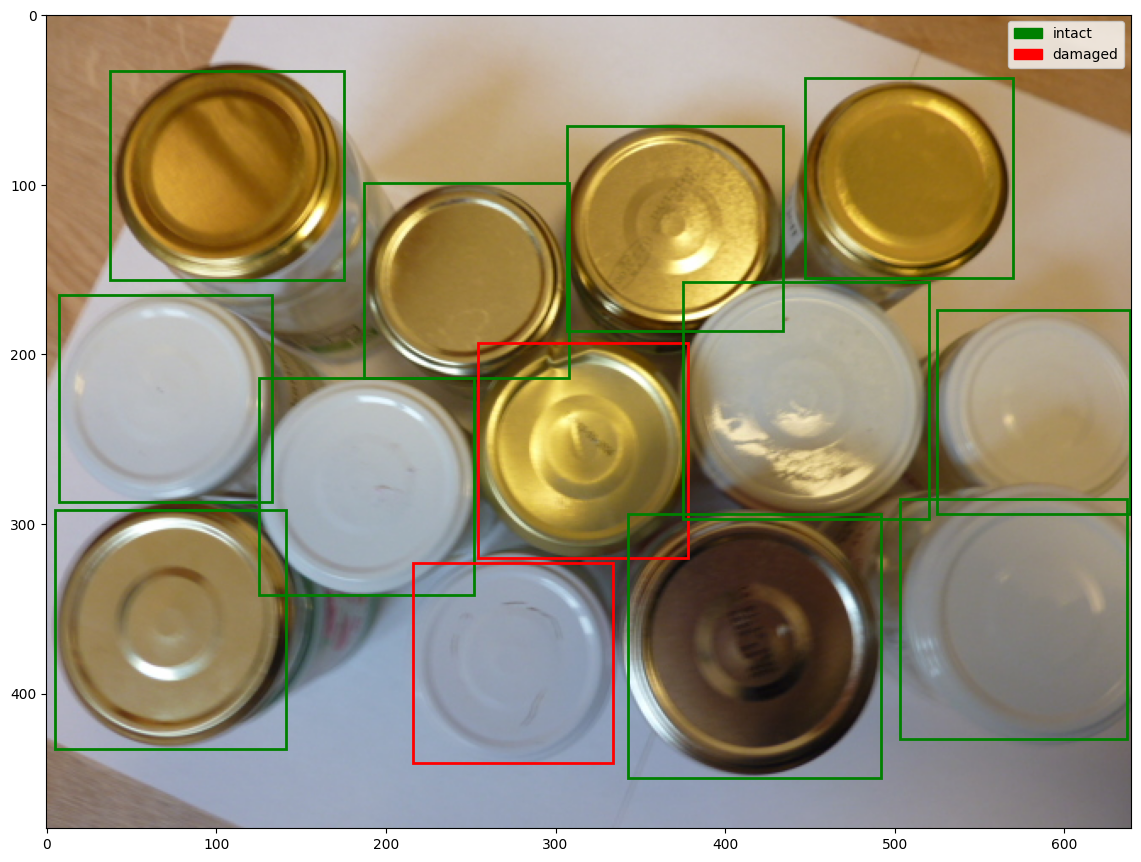

In [28]:
visualisation_annotations(df, imagefiles, 'p15.JPG')

# 4. Bounding Box Size

Bounding box size may be a confounding factor and could be predictive in the train and validation set, while it is not in the unseen testdata. As can be seen in the Raincloud plot below, bounding box width and height was similar for intact and damaged jar lids.

**Bounding Box Width**

Text(0.5, 1.0, 'Bounding box width between intact and damaged jarlids')

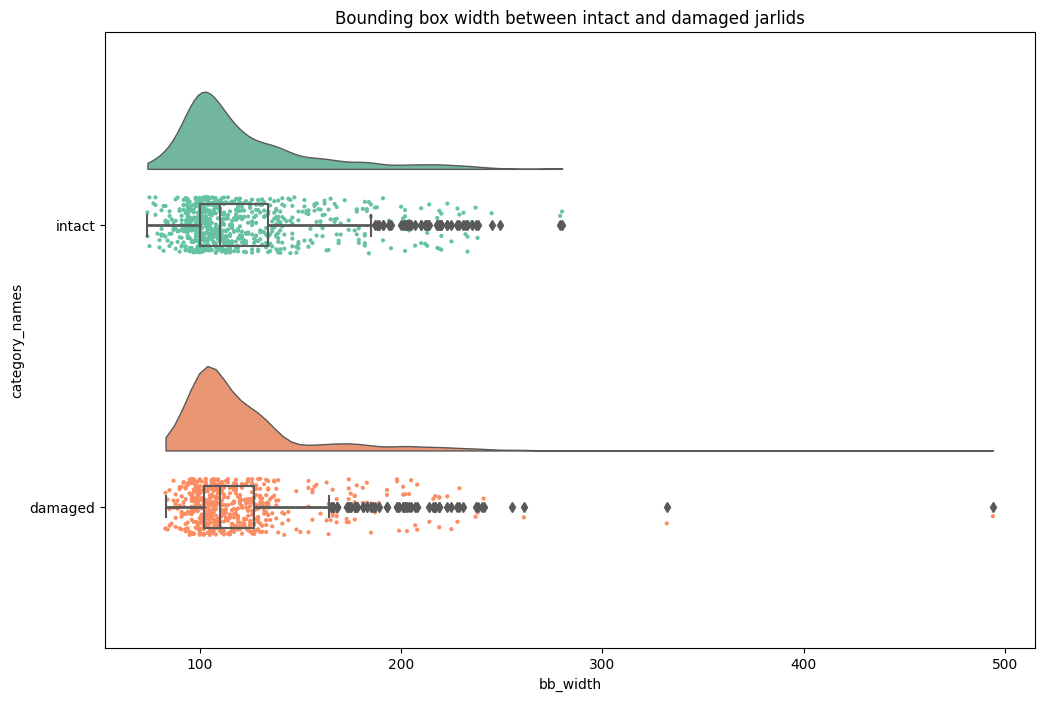

In [29]:
f, ax = plt.subplots(figsize=(12, 8))

pt.RainCloud(x = "category_names", y = "bb_width", data = df[df['dataset'] == 'train'], palette = "Set2", bw = .2,
                 width_viol = .6, ax = ax, orient = "h")

plt.title("Bounding box width between intact and damaged jarlids")

**Bounding Box Height**

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))

pt.RainCloud(x = "category_names", y = "bb_height", data = df[df['dataset'] == 'train'], palette = "Set2", bw = .2,
                 width_viol = .6, ax = ax, orient = "h")

plt.title("Bounding box height between intact and damaged jarlids")

A scatterplot shows that the dimensions of the bounding box have in general similar aspect ratios.

<Axes: xlabel='bb_width', ylabel='bb_height'>

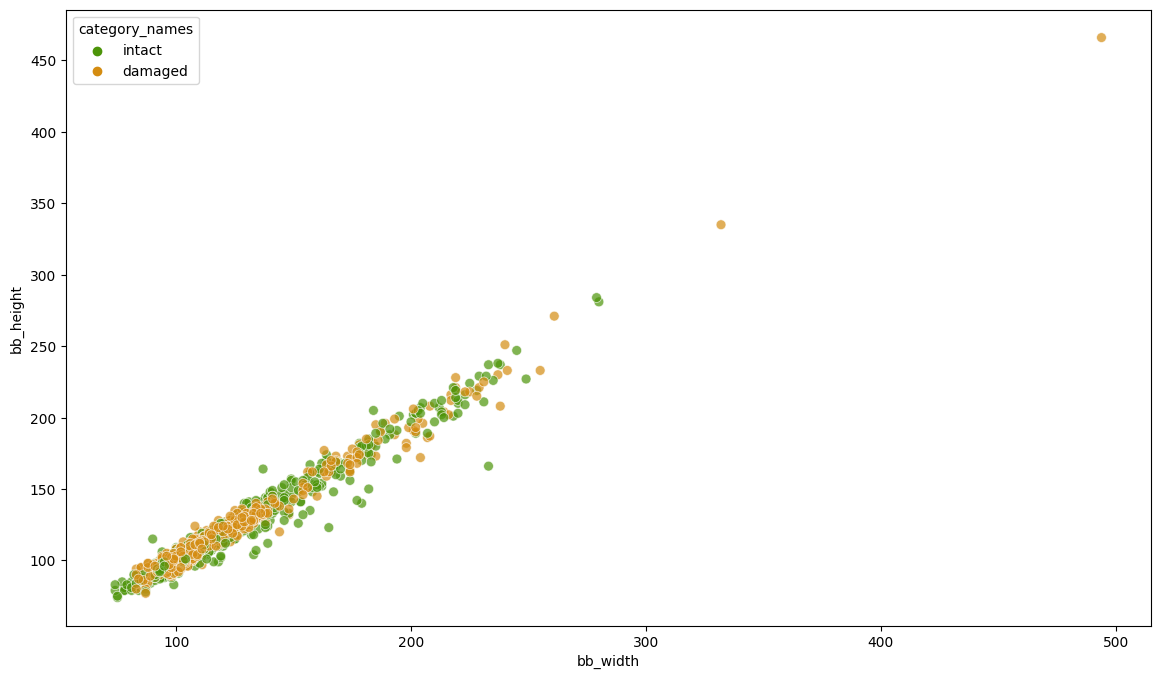

In [30]:
plt.figure(figsize=[14,8])
sns.scatterplot(x='bb_width',
                y='bb_height',
                data=df.loc[df['dataset'] == 'train'].reset_index(),
                hue='category_names',
                alpha=0.7,
                s=50,
                palette=dict(intact="#4c9409", damaged="#d48c11"))

# 5. Class Distribution

There is a slight imbalance between intact and damaged jarlids.

In [31]:
def count_classes(dat, dataset):
    """
    dat: input DataFrame
    dataset: "train", "val", or "test"
    """
    return(df.loc[df['dataset'] == dataset, "category_names"].value_counts())

Class distribution for train data

In [32]:
count_classes(df, "train")

,count
category_names,
intact,727
damaged,622


Class distribution for validation data

In [33]:
count_classes(df, "val")


,count
category_names,
damaged,261
intact,219


# 6. Preparation of Annotations

Preparation of annotations in the format that is needed for Yolov7. First of all, we start by making a directory structure where the image files and annotations can be stored.

In [34]:
prepare_annotations().make_dirstructure()


new directory tree prepared


In [35]:
prepare_annotations().make_labels()


length data: 1859
Emptying labelfiles


In [36]:
prepare_annotations().fixed_train_val_split()


Splitting train and validation data
Removed previous files
No previous files train.txt, val.txt or test.txt were found


In [37]:
prepare_annotations().yaml_file()


Now the data structure is ready for training the object detection model.



In [38]:
# cat /kaggle/working/dest/train.yaml #linux

import yaml

file_path = "/content/dest/train.yaml"

with open(file_path, "r") as file:
    content = yaml.safe_load(file)  # This will parse the YAML file into a Python dictionary
    print(content)


{'yaml': None, 'names': ['damaged', 'intact'], 'nc': 2, 'train': '/content/dest/train.txt', 'val': '/content/dest/val.txt'}


We will look at the annotation data for one image file. The first column displays the category (intact or damaged), the next four columns are the normalized x_center, normalized y_center, normalized width and normalized height of each bounding box.

In [39]:
#cat '/kaggle/working/dest/labels/p1.txt'
# Define the file path
file_path = "/content/dest/labels/p1.txt"  # Use the appropriate path for your local setup

# Open and read the file
with open(file_path, "r") as file:
    content = file.read()  # Read the entire content of the file
    print(content)  # Print the content to the output


1 0.203125 0.2125 0.1875 0.23333333333333334
1 0.396875 0.228125 0.184375 0.20625
0 0.609375 0.17708333333333334 0.225 0.25
1 0.84609375 0.15416666666666667 0.2109375 0.25416666666666665
1 0.16640625 0.4583333333333333 0.1921875 0.24166666666666667
1 0.37890625 0.48125 0.2140625 0.2708333333333333
1 0.6203125 0.4583333333333333 0.246875 0.30833333333333335
1 0.846875 0.4625 0.215625 0.3
1 0.18515625 0.753125 0.2109375 0.29375
1 0.40703125 0.7979166666666667 0.2109375 0.2875
1 0.6265625 0.78125 0.20625 0.275
0 0.85625 0.790625 0.209375 0.28958333333333336



# 7. Training

The model will be trained using data augmentation. In the file `hypownsettings.yaml`, scaling and mosaic are set at 0 since during experiments it turned out that these settings had a negative impact on training. Flip upsidedown is set at 0.5.

In [40]:
os.environ["WANDB_MODE"]="offline"


In [48]:
# !cp '\content\yolov7\cfg\training\yolov7.yaml' '\content\yolov7_ad.yaml'  #source_path then destination file paths
# with open(r'\content\yolov7_ad.yaml') as r:
#   text = r.read().replace("nc: 80", "nc: 2")

import shutil

# Define the source and destination file paths
source_path = '/content/yolov7/cfg/training/yolov7.yaml'
destination_path = '/content/yolov7_ad.yaml'

# Copy the file
shutil.copy(source_path, destination_path)

print("File copied successfully.")





with open(r'/content/yolov7_ad.yaml') as r:
    text = r.read().replace("nc: 80", "nc: 2")


with open(r'/content/yolov7_ad.yaml', "w") as w:
    w.write(text)


File copied successfully.


In [49]:
#!head -5 'C:\Users\Yogesh Dhumal\Downloads\tin defect predection\yolov7_ad.yaml' for linux
# Define the path to the YAML file
file_path = '/content/yolov7_ad.yaml'

# Read and print the first five lines
with open(file_path, 'r') as file:
    for i in range(5):
        line = file.readline()
        print(line.strip())  # Print each line, stripping any extra whitespace


# parameters
nc: 2  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple



In [50]:
cd "/content/yolov7/"

/content/yolov7


In [51]:
# !cp 'data/hyp.scratch.custom.yaml' '/kaggle/working/hypownsettings.yaml'
# with open("/kaggle/working/hypownsettings.yaml") as r:
#   text = r.read().replace("mosaic: 1.0", "mosaic: 0.0").replace("flipud: 0.0", "flipud: 0.5").replace("scale: 0.5", "scale: 0.0")
# with open("/kaggle/working/hypownsettings.yaml", "w") as w:
#   w.write(text)



import shutil

# Define the source and destination file paths
source_path = r'/content/yolov7/data/hyp.scratch.custom.yaml'
destination_path = r'/content/hypownsettings.yaml'

# Copy the file
shutil.copy(source_path, destination_path)

print("File copied successfully.")





with open(r'/content/hypownsettings.yaml') as r:
    text = r.read().replace("nc: 80", "nc: 2")


with open(r'/content/hypownsettings.yaml', "w") as w:
    w.write(text)


File copied successfully.


We will start training. The flag `--image-weights` is used to correct for class imbalance. Training will benefit from pretrained weights.

In [52]:
!pip install protobuf==3.20.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.20.1 which is incompatible.
google-api-core 2.19.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-aiplatform 1.70.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery-connection 1.15.5 requir

In [53]:
# little bit confused regarding this command
#!python train.py --img 640 --batch 16 --epochs 5 --data "C:/Users/Yogesh Dhumal/Downloads/tin defect predection/dest/train.yaml" --hyp 'C:\Users\Yogesh Dhumal\Downloads\tin defect predection\hypownsettings.yaml' --cfg 'C:\Users\Yogesh Dhumal\Downloads\tin defect predection\yolov7_ad.yaml' --weights 'C:\Users\Yogesh Dhumal\Downloads\tin defect predection\yolov7.pt' --cache

In [ ]:
# !python train.py --hyp "C:\Users\Yogesh Dhumal\Downloads\tin defect predection\hypownsettings.yaml" --image-weights --cfg "C:\Users\Yogesh Dhumal\Downloads\tin defect predection\yolov7_ad.yaml" --weights "C:\Users\Yogesh Dhumal\Downloads\tin defect predection\yolov7.pt"


In [54]:
!python train.py --img 640 --batch 2 --epochs 5 --data "/content/dest/train.yaml" --hyp "/content/hypownsettings.yaml" --image-weights --cfg "/content/yolov7_ad.yaml" --weights "/content/yolov7.pt" --cache

2024-11-06 18:21:19.116726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 18:21:19.137061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 18:21:19.143573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 18:21:19.157761: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 18:21:20.223768: W tensorflow/comp

Training gives various files including a `results.txt` file that will in the following line be copied to the Kaggle working space.

In [56]:
!cp '/content/yolov7/runs/train/exp/results.txt' '/content/results.txt'
!cp '/content/yolov7/runs/train/exp/results.png' '/content//results.png'

In [57]:
!cp '/content/yolov7/runs/train/exp/weights/best.pt' '/content//y7-prdef.pt'



# 8. Visualization of the learning curves

To evaluate the results for our purpose, we will look if the bounding boxes are well located around the jar lids and if the predicted class corresponds to the annotated class. To start the visualization, we will need to replace multiple spaces with commas in the `results.txt` file, so we can display performance below.

In [58]:
column_names = ['empty', 'x1', 'x2', 'Box', 'Objectness', 'Classification', 'x3', 'x4', 'x5', 'Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95', 'val_Box', 'val_Obj', 'val_Class']

In [59]:
def text_spaces(inputtext, outputtext, colnames):
    """
    removes spaces and \n from results.txt file and returns data in dataframe
    inputtext: for ex 'results.txt'
    outputtext: for ex 'results.csv'
    colnames: list with columnnames
    """
    dat = pd.DataFrame(columns=colnames)

    with open(inputtext) as f:
        lines = f.readlines()
    print('Length lines:', len(lines))

    for i in range(len(lines)):
        t1 = re.sub(' +', ', ', lines[i])
        t2 = re.sub('\n', '', t1)
        t3 = t2.split(",")
        dat.loc[i] = t3
    dat.to_csv(outputtext)

    return(dat)

In [60]:
df_lcurves = text_spaces(inputtext=results, outputtext='/content/results.txt', colnames=column_names)


Length lines: 5


In [61]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (14, 10))

line1 = ['Box', 'Objectness', 'Classification', 'Precision', 'mAP@0.5']
line2 = ['val_Box', 'val_Obj', 'val_Class', 'Recall', 'mAP@0.5:0.95']
col1 = ['blue', 'blue', 'blue', 'green', 'green']
col2 = ['red', 'red', 'red', 'orange', 'orange']
ylab = ['box_loss', 'obj_loss', 'cls_loss', 'recall and precision', 'mAP']
p1 = ['train', 'train', 'train', 'precision', 'mAP_0.5']
p2 = ['val', 'val', 'val', 'recall', 'mAP_0.5:0.95']

df_lcurves[line1] = df_lcurves[line1].astype(float)
df_lcurves[line2] = df_lcurves[line2].astype(float)

for i in range(len(line1)):

    ax = plt.subplot(3, 2, i+1)
    ax.plot(df_lcurves[line1[i]], '.-', color=col1[i])
    ax.plot(df_lcurves[line2[i]], '.-', color=col2[i])
    ax.set_ylabel(ylab[i])
    patch1 = mpatches.Patch(color=col1[i], label=p1[i])
    patch2 = mpatches.Patch(color=col2[i], label=p2[i])
    ax.legend(handles=[patch1, patch2])

plt.show()

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

The mAP (mean Average Precision) is generally used in object detection to evaluate performance. The curves show an increasing trend even though they seem noisy. Other learning curves like bounding box loss are showing good performance as well.

# 9. Unseen testdata



A few testdata were generated. To test more extensively, a greater variety of images should be used.



In [ ]:
prepare_annotations(yamlfile='test_design.yaml', validationtest='test.txt').yaml_file()


In [ ]:
!python test.py --data /kaggle/working/dest/test_design.yaml --weights '/kaggle/working/yolov7/runs/train/exp/weights/best.pt' --augment

In [ ]:
Image.open('/kaggle/working/yolov7/runs/test/exp/test_batch0_labels.jpg')


# 11. Save the Best Model

In [ ]:
!ls

In [ ]:
!cd \runs

In [ ]:
!ls

In [ ]:
!python export.py --img-size 640 --batch-size 16 --weights '/kaggle/working/yolov7/runs/train/exp/weights/best.pt'

/kaggle/working/yolov7/runs/train/exp/weights/best.onnx

# 12. Check ONNX

In [ ]:
from onnx2pytorch import ConvertModel

In [ ]:
!python test.py --data /kaggle/working/dest/test_design.yaml --weights '/kaggle/working/yolov7/runs/train/exp/weights/best.onnx' --augment


# 10. Deploy to HuggingFace